# Demo for keyword recognition

### Installation and imports

In [ ]:
!pip install tensorflow

In [84]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import seaborn as sns

#for reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Data preparation

### Importing data

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 7s 0us/step


In [4]:
def count_samples(_class):
    DATASET_PATH = r'data/mini_speech_commands'
    dir_path = os.path.join(DATASET_PATH,_class)
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    return count

NOTE: make our cutted words the same format

In [5]:
count_samples("down")

1000

In [6]:
keywords = np.array(tf.io.gfile.listdir(str(data_dir)))
keywords = keywords[(keywords != 'README.md') & (keywords!='.DS_Store') & (keywords != '.ipynb_checkpoints')]
print('Keywords:', keywords)

Keywords: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## Creating dataset

In [92]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


tf.keras.utils.audio_dataset_from_directory makes the audio files the same length:
output_sequence_length
Maximum length of an audio sequence. Audio files longer than this will be truncated to output_sequence_length. If set to None, then all sequences in the same batch will be padded to the length of the longest sequence in the batch.
Also automatically shuffles the data.
Subset: both: returns both the training and validation set also

In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [94]:
for example_audio, example_labels in train_ds.take(1):
    break

In [95]:
print(example_audio[10])

tf.Tensor(
[[ 1.2207031e-04]
 [ 4.5776367e-04]
 [ 5.4931641e-04]
 ...
 [-9.1552734e-05]
 [-2.1362305e-04]
 [-4.2724609e-04]], shape=(16000, 1), dtype=float32)


In [12]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [13]:
#split val_ds into to sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [15]:
#iterating through the dataset
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


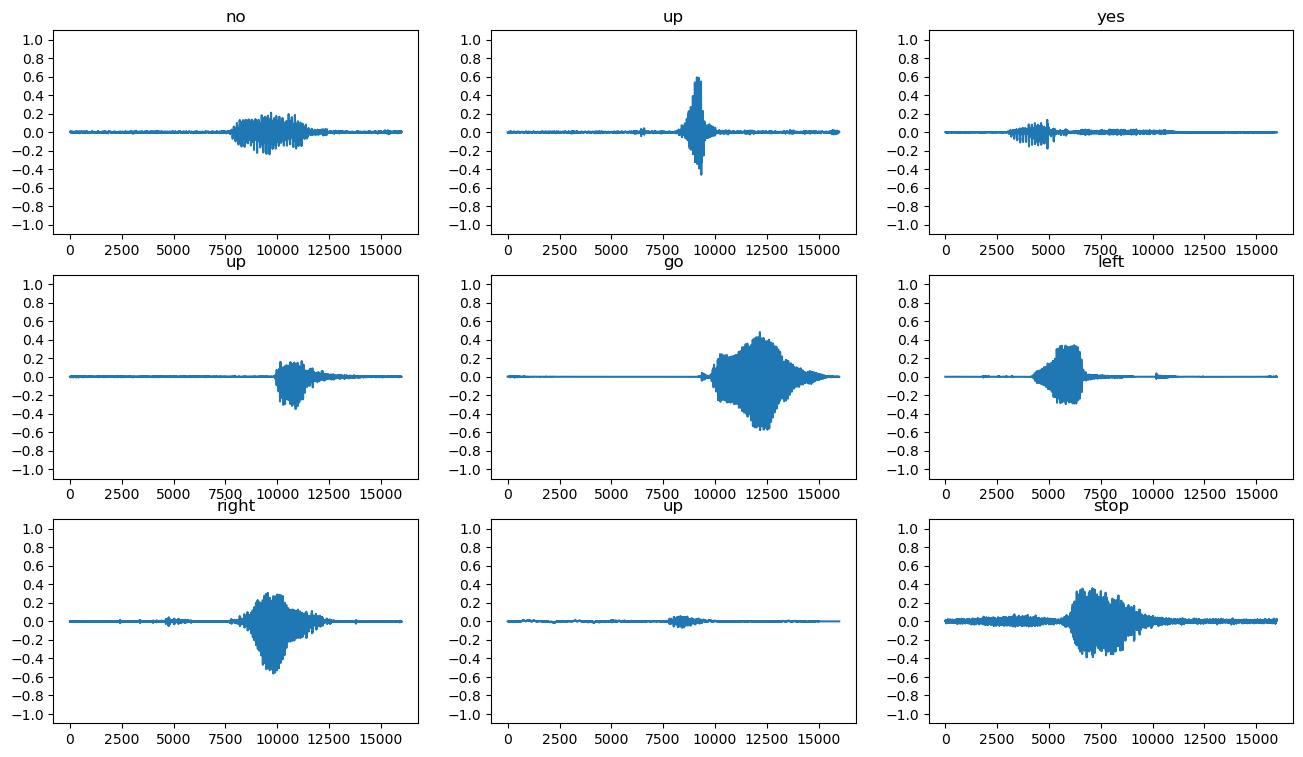

In [16]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [29]:
def visualize_waveform(audio,label):  
    plt.plot(audio.numpy())
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1,1.1])
    plt.title(label)
    
    plt.show()

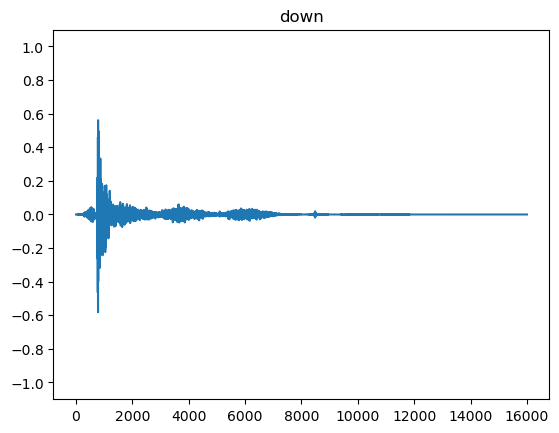

In [32]:
visualize_waveform(example_audio[20],label_names[int(example_labels[20])])

### Waveform into spectrogram

In [44]:
def convert_into_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform,frame_length=255,frame_step=128) 
    spectrogram = tf.abs(spectrogram)
    #+1 dummy dimenzióval megtoldjuk azért, hogy
    # olyan formátumba legyen ahogy a képek is szoktak
    spectrogram = spectrogram[...,tf.newaxis]
    return spectrogram

In [45]:
# Exploring the spectrograms data:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = convert_into_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [53]:
def visualize_spectrogram(spectrogram,label):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)
    plt.title(label)

In [57]:
def visualize_sample(idx):
    label = label_names[int(example_labels[idx])]
    audio = example_audio[idx]
    spectrogram = convert_into_spectrogram(example_audio[idx])
    visualize_waveform(audio,label)
    visualize_spectrogram(spectrogram,label)
    display.display(display.Audio(audio, rate=16000))

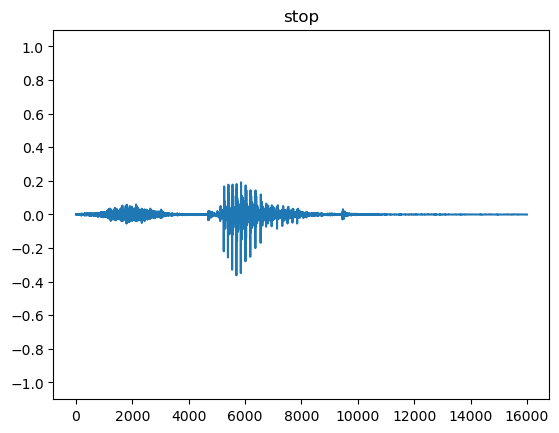

C:\Users\zsomb\AppData\Local\Temp\ipykernel_7644\2799036210.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, log_spec)


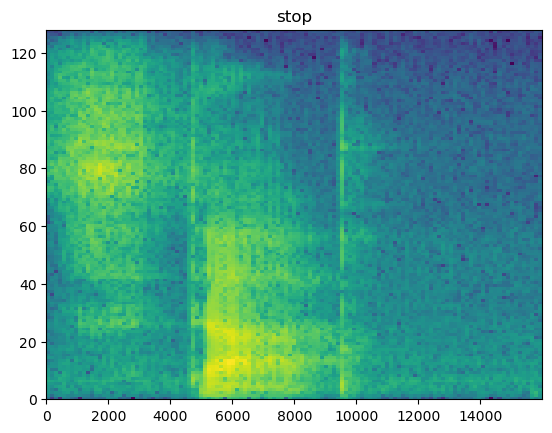

In [59]:
visualize_sample(32)

### Transform audio dataset into spectrogram dataset

In [65]:
def convert_to_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (convert_into_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [66]:
train_spectrogram_ds = convert_to_spec_ds(train_ds)
val_spectrogram_ds = convert_to_spec_ds(val_ds)
test_spectrogram_ds = convert_to_spec_ds(test_ds)

### Reduce latency

In [70]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [71]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

C:\Users\zsomb\AppData\Local\Temp\ipykernel_7644\2799036210.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, log_spec)


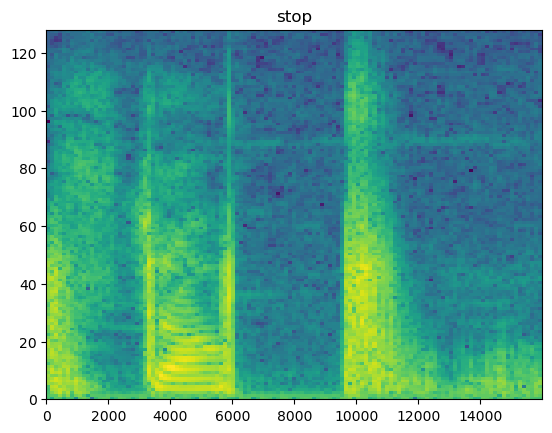

In [73]:
visualize_spectrogram(example_spectrograms[40],label_names[example_spect_labels[40]])

### Build model

In [74]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Training

In [78]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 22s 217ms/step - loss: 1.7275 - accuracy: 0.3759 - val_loss: 1.2982 - val_accuracy: 0.6055
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 1.1656 - accuracy: 0.5923 - val_loss: 0.9380 - val_accuracy: 0.6940
Epoch 3/10
100/100 [==============================] - 13s 130ms/step - loss: 0.8901 - accuracy: 0.6836 - val_loss: 0.7588 - val_accuracy: 0.7409
Epoch 4/10
100/100 [==============================] - 13s 127ms/step - loss: 0.7263 - accuracy: 0.7367 - val_loss: 0.7042 - val_accuracy: 0.7669
Epoch 5/10
100/100 [==============================] - 13s 128ms/step - loss: 0.6337 - accuracy: 0.7686 - val_loss: 0.6080 - val_accuracy: 0.8008
Epoch 6/10
100/100 [==============================] - 13s 129ms/step - loss: 0.5561 - accuracy: 0.8014 - val_loss: 0.5836 - val_accuracy: 0.8151
Epoch 7/10
100/100 [==============================] - 13s 126ms/step - loss: 0.5018 - accuracy: 0.8230 - val_loss: 0.5204 - val_ac

In [79]:
def plot_training_history(history):
    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]') 

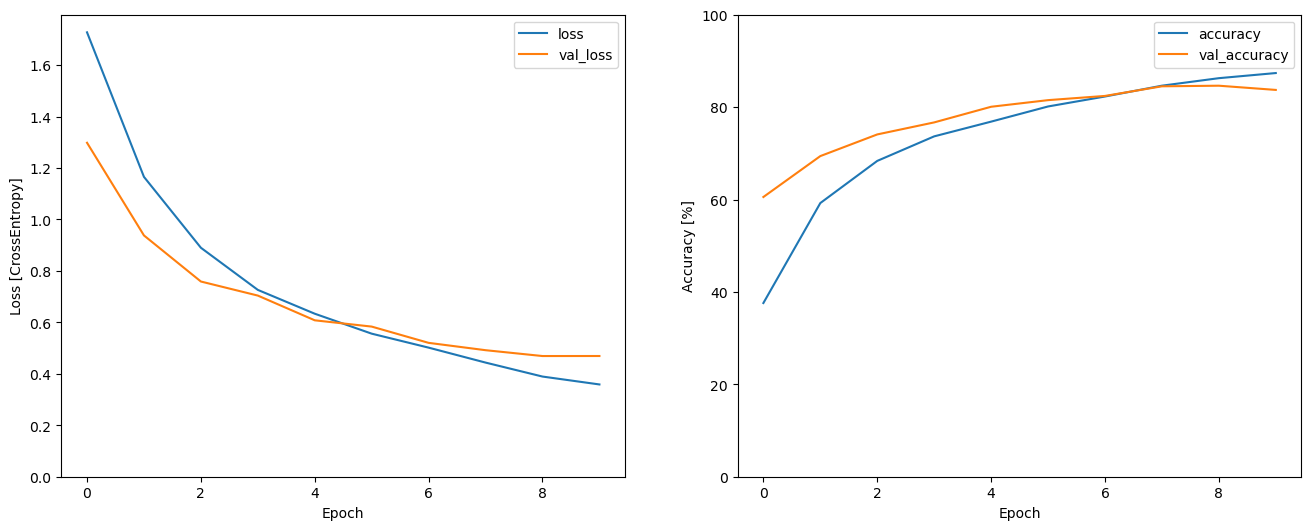

In [80]:
plot_training_history(history)

### Evaluate the model perforamce

In [82]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 16ms/step - loss: 0.4922 - accuracy: 0.8450


{'loss': 0.49221161007881165, 'accuracy': 0.8449519276618958}

13/13 [==============================] - 0s 21ms/step


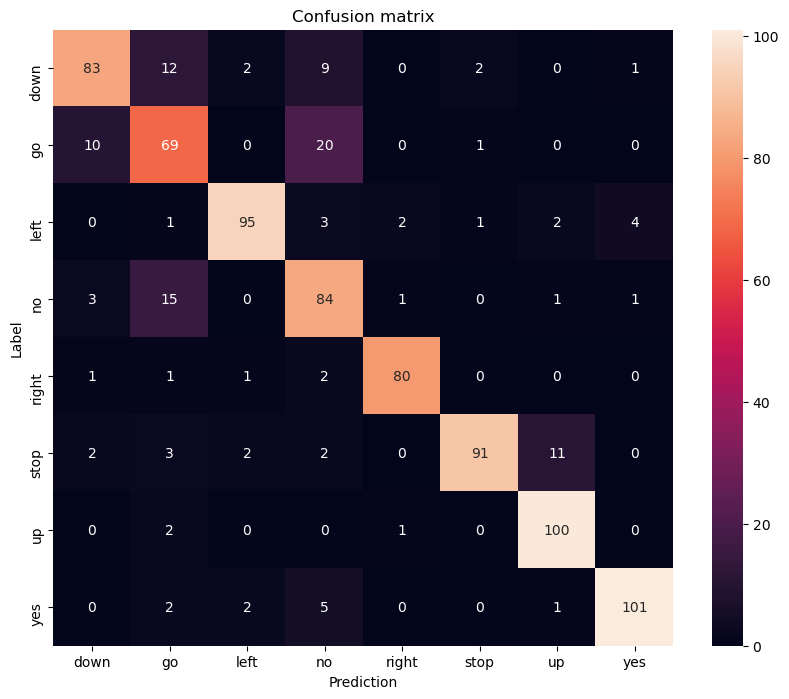

In [86]:
### Displaying confusion matrix
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title("Confusion matrix")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()